# 02 - Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
sns.set_context('notebook')
sns.set_palette('deep')
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

### Aux. Functions

In [173]:
def subset_by_route(df, route):
    if type(route) is str:
        orig = route.split('-')[0]
        dest = route.split('-')[1]
    else:
        orig = route[0]
        dest = route[1]
    df = df[(df['flyFrom'] == orig) & (df['flyTo'] == dest)]
    return df

In [204]:
def plot_hist_price_by_route(df, log=True):
    df = df.copy()
    routes = df['flyFrom'] +'-'+ df['flyTo']
    routes = routes.unique()
    if log:
        df['price'] = np.log(df['price'])
    f, axes = plt.subplots(2, 5, figsize=(15,9));
    axes = axes.ravel();
    for idx, route in enumerate(routes):
        df_route = subset_by_route(df,route)
        sns.histplot(df_route['price'], kde=False, ax=axes[idx]);
        axes[idx].set_title(route)
    plt.tight_layout()
        

### Load data

In [3]:
flights = pd.read_csv('../data/interim/flights_interim.csv')

In [4]:
flights.head()

,collectionDate,dDate,dTime,aDate,aTime,dTimeUTC,aTimeUTC,flyFrom,flyTo,airlines,...,distance,route,price,seats,cityFrom,cityCodeFrom,cityTo,cityCodeTo,countryFrom,countryTo
0,2021-01-31,2021-02-01,15:00,2021-02-01,16:25,2021-02-01 14:00:00,2021-02-01 15:25:00,MAD,BCN,UX,...,483.25,MAD -> BCN,78,NaN,Madrid,MAD,Barcelona,BCN,Spain,Spain
1,2021-01-31,2021-02-01,09:35,2021-02-01,10:50,2021-02-01 08:35:00,2021-02-01 09:50:00,MAD,BCN,VY,...,483.25,MAD -> BCN,91,NaN,Madrid,MAD,Barcelona,BCN,Spain,Spain
2,2021-01-31,2021-02-01,19:45,2021-02-01,21:05,2021-02-01 18:45:00,2021-02-01 20:05:00,MAD,BCN,IB,...,483.25,MAD -> BCN,91,5.0,Madrid,MAD,Barcelona,BCN,Spain,Spain
3,2021-01-31,2021-02-01,19:15,2021-02-02,08:50,2021-02-01 18:15:00,2021-02-02 07:50:00,MAD,BCN,UX,...,483.25,MAD -> BCN,108,3.0,Madrid,MAD,Barcelona,BCN,Spain,Spain
4,2021-01-31,2021-02-01,14:50,2021-02-02,08:50,2021-02-01 13:50:00,2021-02-02 07:50:00,MAD,BCN,UX,...,483.25,MAD -> BCN,112,3.0,Madrid,MAD,Barcelona,BCN,Spain,Spain


### Features Overview

In [5]:
flights.columns

Index(['collectionDate', 'dDate', 'dTime', 'aDate', 'aTime', 'dTimeUTC',
       'aTimeUTC', 'flyFrom', 'flyTo', 'airlines', 'flight_no', 'fly_duration',
       'distance', 'route', 'price', 'seats', 'cityFrom', 'cityCodeFrom',
       'cityTo', 'cityCodeTo', 'countryFrom', 'countryTo'],
      dtype='object')

Target:
* price: Ticket price of a flight

Features:
* **collectionDate**: date flight data was taken
* **dDate**: departure day
* **dTime**: departure time
* **aDate**: arrival day
* **aTime**: arrival time
* **dTimeUTC**, **aTimeUTC**: departure and arrival time in UTC timezone
* **flyFrom**: origin airport IATA code
* **flyTo**: destination airport IATA code
* **airlines**: self-explanatory
* **flight_no**: identification plain number
* **fly_duration**, **distance**: self-explanatory
* **route**: airports through flight passes
* **seats**: availability
* **cityFrom**, **cityCodeFrom**, **cityTo**, **cityCodeTo**: different id's for the origin and destination cities
* **countryFrom**, **countryTo**: origin and dest countries

Numerical: distance, fly_duration, seats, price
\
Categorical: flyFrom, flyTo, airlines, route

In [5]:
flights[['distance', 'fly_duration', 'seats','price']].describe()

,distance,fly_duration,seats,price
count,421891.000000,421891.000000,330425.000000,421891.000000
mean,4229.032140,20.965639,2.584611,342.841604
std,3661.938875,12.084302,2.342160,412.524986
min,202.180000,0.750000,1.000000,20.000000
25%,1110.280000,12.750000,1.000000,107.000000
50%,1774.110000,20.583333,1.000000,260.000000
75%,9075.770000,27.500000,4.000000,399.000000
max,10097.940000,60.000000,8.000000,8840.000000


In [6]:
# TODO: comment descriptive statitics when I have final dataset

### Price

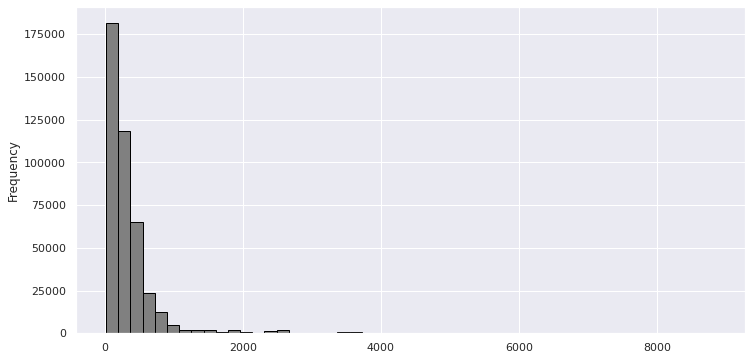

In [62]:
flights['price'].plot(kind='hist', 
                            bins=50, 
                            figsize=(12,6), 
                            facecolor='grey',
                            edgecolor='black');

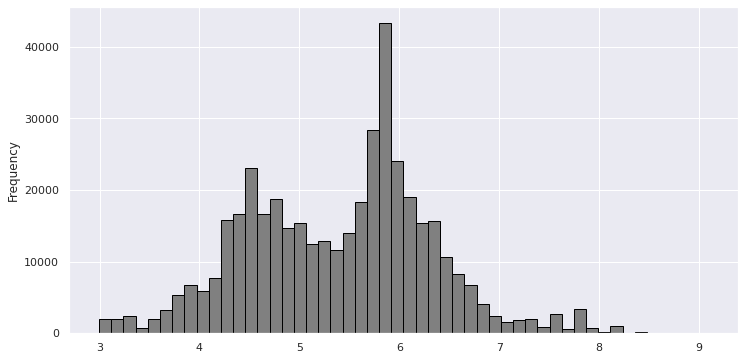

In [63]:
flights['log_price'] = np.log(flights['price'])
flights['log_price'].plot(kind='hist', 
                            bins=50, 
                            figsize=(12,6), 
                            facecolor='grey',
                            edgecolor='black');

#### Log-Price histogram by route

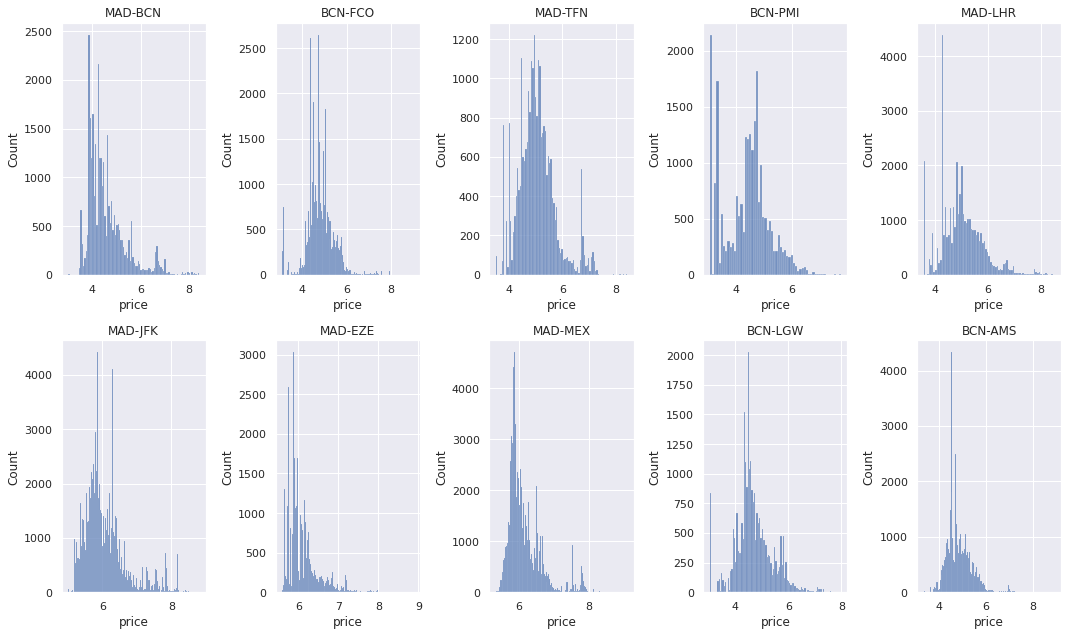

In [205]:
plot_hist_price_by_route(flights, log=True);

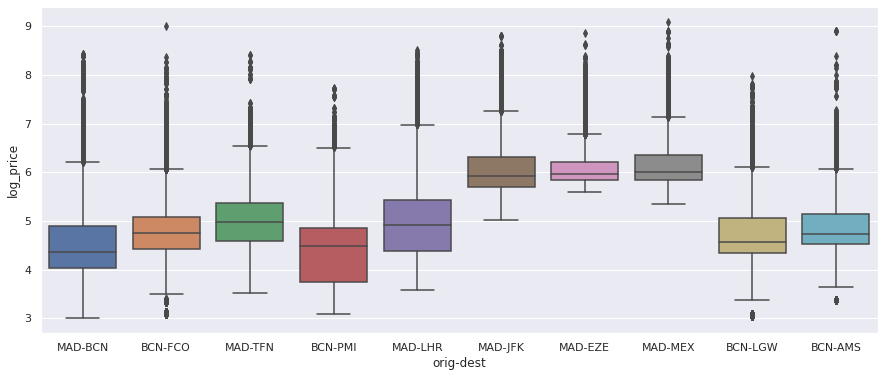

In [201]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='orig-dest', y='log_price', data=flights);

* As expected, longest routes have more expensive fares
* Many outliers

### CollectionDate

In [27]:
flights['collectionDate'].head()

0    2021-01-31
1    2021-01-31
2    2021-01-31
3    2021-01-31
4    2021-01-31
Name: collectionDate, dtype: object

* Day that data was collected. We can use this variable to compute a new 'Days to departure' numerical variable using this column and departure date colunm.

### FlyFrom, FlyTo

We have collected flights of 10 routes:

In [35]:
routes = flights['flyFrom'] +'-'+ flights['flyTo']

In [36]:
routes.unique()

array(['MAD-BCN', 'BCN-FCO', 'MAD-TFN', 'BCN-PMI', 'MAD-LHR', 'MAD-JFK',
       'MAD-EZE', 'MAD-MEX', 'BCN-LGW', 'BCN-AMS'], dtype=object)

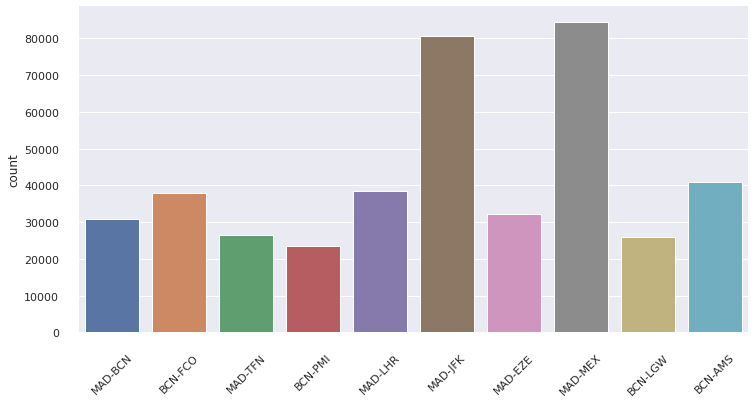

In [60]:
plt.figure(figsize=(12,6))
sns.countplot(routes)
sns.despine(offset=10, trim=True);
plt.xticks(rotation=45);

* MAD-JFK (Madrid-New York) and MAD-MEX (Madrid-Mexico City) are the busiest routes. The rest of them have a similar traffic.
* Maybe we can add a new categorical variable with the route. 

### Airlines

### Flight_no

### Fly_duration

### Distance

### Route

### Seats

### City Aliases¿?

In [9]:
# TODO: hacerme un selector de rutas
# TODO: plotear los histogramas del precio por ruta
# Generalista o por rutas?

In [20]:
# Selecting Madrid-London route
mad_lon = subset_by_route(flights, ('MAD', 'LHR'))

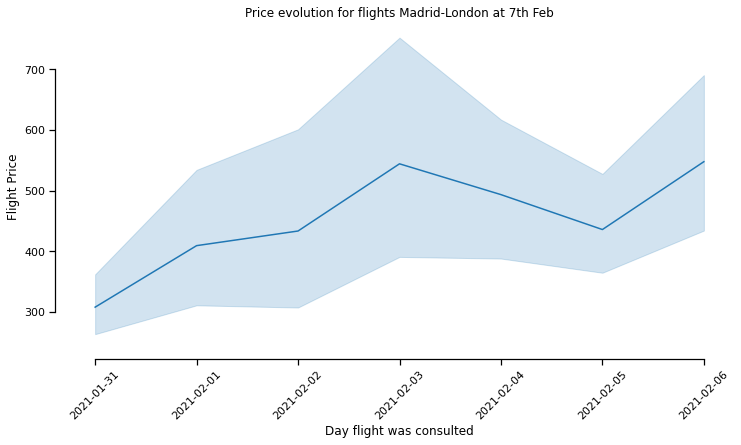

In [11]:
departure_day = '2021-02-07'
mad_lon_07_02 = mad_lon[mad_lon['dDate'] == departure_day]
mad_lon_07_02.groupby('collectionDate')['price'].mean()
plt.figure(figsize=(12,6))
sns.lineplot(x='collectionDate', y='price',data=mad_lon_07_02);
#plt.plot(mad_lon_07_02['collectionDate'], mad_lon_07_02['price'])
plt.xlabel('Day flight was consulted');
plt.ylabel('Flight Price')
plt.title('Price evolution for flights Madrid-London at 7th Feb');
sns.despine(offset=10, trim=True);
plt.xticks(rotation=45);
